# Casos prácticos

Este notebook, by [Felipe Alonso Atienza](www.linkedin.com/in/felipe-alonso-atienza)

En este notebook vamos a abordar dos casos prácticos interesantes.

1. Predicción (*forecasting*) de la demanda de bicicletas
2. Clasificación multiclase de imágenes

## Librerías y funciones

Lo primero es cargar las librerías y funciones necesarias.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

In [2]:
def plot_confusion_matrix(confmat):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    plt.show()

# 1. Predicción de la demanda de bicicletas

El problema está descrito [aquí](https://christophm.github.io/interpretable-ml-book/bike-data.html), y los datos pueden descargarse en la [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset), aunque los hemos modificado un poco para hacer el problema más parecido al [*challenge*](https://www.kaggle.com/c/bike-sharing-demand/data) original.

In [3]:
data = pd.read_csv('./data/bikes.csv',sep=';', decimal='.')
data.head()

,instant,dteday,season,holiday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1-1-2011,1,0,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2-1-2011,1,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,3-1-2011,1,0,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,4-1-2011,1,0,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,5-1-2011,1,0,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


<div class = "alert alert-success">
**EJERCICIO**: Interprete los datos y realiza tus primeras hipótesis sobre qué variables son de interés
</div>

<div class = "alert alert-success">
**EJERCICIO**: Elimine las columnas *instant*, *casual* y *registered*
</div>

In [4]:
# your code here
data = data.drop(['instant','casual','registered'],axis=1)

In [5]:
data.shape

(731, 10)

In [6]:
data.tail()

,dteday,season,holiday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
726,27-12-2012,1,0,1,2,0.254167,0.226642,0.652917,0.350133,2114
727,28-12-2012,1,0,1,2,0.253333,0.255046,0.590000,0.155471,3095
728,29-12-2012,1,0,0,2,0.253333,0.242400,0.752917,0.124383,1341
729,30-12-2012,1,0,0,1,0.255833,0.231700,0.483333,0.350754,1796
730,31-12-2012,1,0,1,2,0.215833,0.223487,0.577500,0.154846,2729


In [7]:
data.dtypes

dteday         object
season          int64
holiday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
dtype: object

In [8]:
data.isnull().any()

dteday        False
season        False
holiday       False
workingday    False
weathersit    False
temp          False
atemp         False
hum           False
windspeed     False
cnt           False
dtype: bool

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
season,731.0,2.496580,1.110807,1.000000,2.000000,3.000000,3.000000,4.000000
holiday,731.0,0.028728,0.167155,0.000000,0.000000,0.000000,0.000000,1.000000
workingday,731.0,0.683995,0.465233,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,731.0,1.395349,0.544894,1.000000,1.000000,1.000000,2.000000,3.000000
temp,731.0,0.495385,0.183051,0.059130,0.337083,0.498333,0.655417,0.861667
atemp,731.0,0.474354,0.162961,0.079070,0.337842,0.486733,0.608602,0.840896
hum,731.0,0.627894,0.142429,0.000000,0.520000,0.626667,0.730209,0.972500
windspeed,731.0,0.190486,0.077498,0.022392,0.134950,0.180975,0.233214,0.507463
cnt,731.0,4504.348837,1937.211452,22.000000,3152.000000,4548.000000,5956.000000,8714.000000


## 1.1 *Feature Engineering*

Vamos a trabajar con las fechas para crear algunas variables auxiliares

In [10]:
from datetime import datetime

data['dteday'] = data['dteday'].apply(lambda x: datetime.strptime(x,'%d-%m-%Y'))
data.head()

,dteday,season,holiday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01,1,0,0,2,0.344167,0.363625,0.805833,0.160446,985
1,2011-01-02,1,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,2011-01-03,1,0,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,2011-01-04,1,0,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,2011-01-05,1,0,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [13]:
data.dtypes

dteday        datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
cnt                    int64
dtype: object

In [11]:
data['year'] = data['dteday'].apply(lambda x: x.year - 2011)
data.head()

,dteday,season,holiday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,year
0,2011-01-01,1,0,0,2,0.344167,0.363625,0.805833,0.160446,985,0
1,2011-01-02,1,0,0,2,0.363478,0.353739,0.696087,0.248539,801,0
2,2011-01-03,1,0,1,1,0.196364,0.189405,0.437273,0.248309,1349,0
3,2011-01-04,1,0,1,1,0.200000,0.212122,0.590435,0.160296,1562,0
4,2011-01-05,1,0,1,1,0.226957,0.229270,0.436957,0.186900,1600,0


In [12]:
data['month'] = data['dteday'].apply(lambda x: x.month)
data.head()

,dteday,season,holiday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,year,month
0,2011-01-01,1,0,0,2,0.344167,0.363625,0.805833,0.160446,985,0,1
1,2011-01-02,1,0,0,2,0.363478,0.353739,0.696087,0.248539,801,0,1
2,2011-01-03,1,0,1,1,0.196364,0.189405,0.437273,0.248309,1349,0,1
3,2011-01-04,1,0,1,1,0.200000,0.212122,0.590435,0.160296,1562,0,1
4,2011-01-05,1,0,1,1,0.226957,0.229270,0.436957,0.186900,1600,0,1


In [13]:
data.tail()

,dteday,season,holiday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,year,month
726,2012-12-27,1,0,1,2,0.254167,0.226642,0.652917,0.350133,2114,1,12
727,2012-12-28,1,0,1,2,0.253333,0.255046,0.590000,0.155471,3095,1,12
728,2012-12-29,1,0,0,2,0.253333,0.242400,0.752917,0.124383,1341,1,12
729,2012-12-30,1,0,0,1,0.255833,0.231700,0.483333,0.350754,1796,1,12
730,2012-12-31,1,0,1,2,0.215833,0.223487,0.577500,0.154846,2729,1,12


In [14]:
data['weekday'] = data['dteday'].apply(lambda x: x.isoweekday())
data.head()

,dteday,season,holiday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,year,month,weekday
0,2011-01-01,1,0,0,2,0.344167,0.363625,0.805833,0.160446,985,0,1,6
1,2011-01-02,1,0,0,2,0.363478,0.353739,0.696087,0.248539,801,0,1,7
2,2011-01-03,1,0,1,1,0.196364,0.189405,0.437273,0.248309,1349,0,1,1
3,2011-01-04,1,0,1,1,0.200000,0.212122,0.590435,0.160296,1562,0,1,2
4,2011-01-05,1,0,1,1,0.226957,0.229270,0.436957,0.186900,1600,0,1,3


Llegados a este punto, podemos eliminar la variable *dteday*

In [15]:
data = data.drop(['dteday'],axis=1)
data.head()

,season,holiday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,year,month,weekday
0,1,0,0,2,0.344167,0.363625,0.805833,0.160446,985,0,1,6
1,1,0,0,2,0.363478,0.353739,0.696087,0.248539,801,0,1,7
2,1,0,1,1,0.196364,0.189405,0.437273,0.248309,1349,0,1,1
3,1,0,1,1,0.200000,0.212122,0.590435,0.160296,1562,0,1,2
4,1,0,1,1,0.226957,0.229270,0.436957,0.186900,1600,0,1,3


## 1.2 Análisis de correlación

<div class = "alert alert-success">
**EJERCICIO**: Represente la variable *temp* vs *atemp*.
</div>

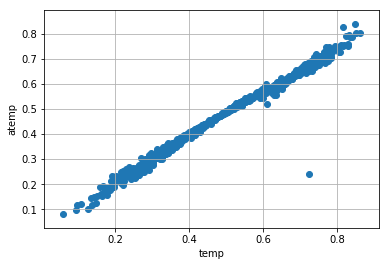

In [16]:
# your code here
plt.scatter(data.temp,data.atemp)
plt.xlabel('temp')
plt.ylabel('atemp')
plt.grid()
plt.show()

A la vista está que son variables altamente correlacionadas. Podemos eliminar *temp*, ya que nos afecta más la sensación térmica que la temperatura real.

In [17]:
data = data.drop(['temp'],axis=1)
data.head()

,season,holiday,workingday,weathersit,atemp,hum,windspeed,cnt,year,month,weekday
0,1,0,0,2,0.363625,0.805833,0.160446,985,0,1,6
1,1,0,0,2,0.353739,0.696087,0.248539,801,0,1,7
2,1,0,1,1,0.189405,0.437273,0.248309,1349,0,1,1
3,1,0,1,1,0.212122,0.590435,0.160296,1562,0,1,2
4,1,0,1,1,0.229270,0.436957,0.186900,1600,0,1,3


<div class = "alert alert-success">
**EJERCICIO**(@home): Realice un análisis exploratorio exhaustivo.
</div>

# 1.3 Codificación de variables categóricas

Tenemos varias variables categóricas: *season*, *weathersit*, *month* y *weekday*. Cuando trabajamos con series temporales, es común crear variables *dummies* asociadas a cada una de las situaciones de las variables categóricas. Para ello, tenemos dos opciones:

- [pd.get_dummies()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html): se aplica directamente sobre el dataframe puede [utilizarse](https://towardsdatascience.com/the-dummys-guide-to-creating-dummy-variables-f21faddb1d40) con strings directamente. La pega es que genera un nuevo dataframe que hay que agregar al original.
- [OneHotEncoding()](http://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features): sobre la matriz de datos (X), genera variables dummies sobre las columnas que se indique. Es muy sencillo de implementar, pero requiere que los datos hayan sido codificados previamente como enteros (labelEncoder()).

La codificación "dummy" de variables categóricas en problemas de clasificación/regresión es opcional, como vimos anteriormente, pero en series temporales resulta adecuado para explicar el efecto de una situación temporal en la variable target.

Vamos a utilizar los dos métodos para codificar las variables categóricas.  

<div class = "alert alert-success">
**EJERCICIO**(@home): Prueba no realizar esta codificación "dummy" y entrena un modelo de machine learning para predecir la demanda de bicicletas.
</div>

Comenzamos por la variable *season*. Veamos qué hace *get_dummies()*.

In [23]:
pd.get_dummies(data['season'], prefix = 'season')

,season_1,season_2,season_3,season_4
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
5,1,0,0,0
6,1,0,0,0
7,1,0,0,0
8,1,0,0,0
9,1,0,0,0


In [18]:
dummy = pd.get_dummies(data['season'], prefix = 'season')

data = pd.concat([data,dummy],axis=1).drop(['season'],axis=1)
data.head()

,holiday,workingday,weathersit,atemp,hum,windspeed,cnt,year,month,weekday,season_1,season_2,season_3,season_4
0,0,0,2,0.363625,0.805833,0.160446,985,0,1,6,1,0,0,0
1,0,0,2,0.353739,0.696087,0.248539,801,0,1,7,1,0,0,0
2,0,1,1,0.189405,0.437273,0.248309,1349,0,1,1,1,0,0,0
3,0,1,1,0.212122,0.590435,0.160296,1562,0,1,2,1,0,0,0
4,0,1,1,0.229270,0.436957,0.186900,1600,0,1,3,1,0,0,0


In [19]:
# preparamos los datos
features = data.columns.drop(['cnt'])
X = data[features].values
y = data['cnt'].values

print('Filas, columnas', X.shape)

Filas, columnas (731, 13)


In [20]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(categorical_features = [2,8,9], sparse=False, n_values=[3,12,7]) #weathersit, month, weekday
X = enc.fit_transform(X)
print('Filas, columnas', X.shape)

Filas, columnas (731, 32)


## 1.4 División train/test 

In [22]:
offset = 100 # 0.25 of 731

X_train = X[:-offset, :]
y_train = y[:-offset]
X_test  = X[-offset:, :]
y_test  = y[-offset:]


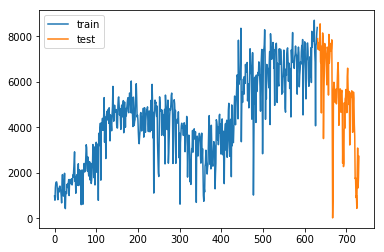

In [21]:
# Paso 1:
offset = 100 # 0.25 of 731

X_train = X[:-offset, :]
y_train = y[:-offset]
X_test  = X[-offset:, :]
y_test  = y[-offset:]

plt.plot(range(0,len(y_train)),y_train, label='train')
plt.plot(range(len(y_train),len(y)),y_test,label='test')
plt.legend()
plt.show()

## 1.5 Búsqueda de parámetros libres

In [33]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Lasso

tscv = TimeSeriesSplit(n_splits=3)

alpha_vector = np.logspace(-4,4,20)
param_grid = {'alpha': alpha_vector}

grid = GridSearchCV(Lasso(), param_grid=param_grid, cv = tscv.split(X_train)).fit(X_train, y_train)

best mean cross-validation score: -0.483
best parameters: {'alpha': 0.23357214690901212}


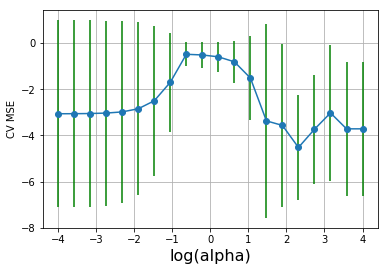

In [34]:
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']
plt.errorbar(np.log10(alpha_vector),scores,yerr=std_scores, fmt='o-',ecolor='g')
plt.xlabel('log(alpha)',fontsize=16)
plt.ylabel('CV MSE')
plt.grid()
plt.show()

## 1.6 Métricas en test

In [35]:
from sklearn.metrics import mean_squared_error

alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(X_train,y_train)

ytrainLasso = lasso.predict(X_train)
ytestLasso  = lasso.predict(X_test)

mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

w = lasso.coef_
for f,wi in zip(features,w):
    print(f,wi)

MSE Modelo Lasso (train): 5.32e+05
MSE Modelo Lasso (test) : 1.83e+06
holiday 0.0
workingday 443.90892986
weathersit -0.0
atemp -1350.51192615
hum -110.512600495
windspeed -8.49305108333
year -0.0
month 56.3487995074
weekday 102.35861682
season_1 113.510015621
season_2 -227.942730495
season_3 0.0
season_4 0.0


<div class = "alert alert-success">
**EJERCICIO**: Representa la predicción obtenida junto con la serie real (train+test)
</div>

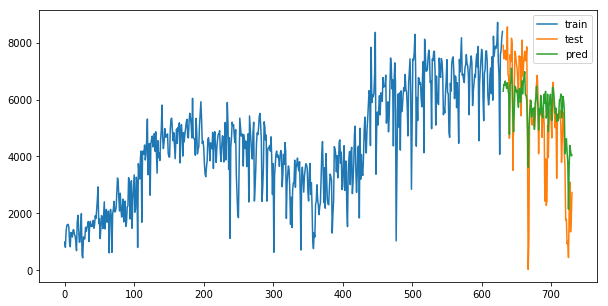

In [36]:
# your code here
plt.figure(figsize=(10,5))
plt.plot(range(0,len(y_train)),y_train, label='train')
plt.plot(range(len(y_train),len(y)),y_test,label='test')
plt.plot(range(len(y_train),len(y)),ytestLasso,label='pred')
plt.legend()
plt.show()

# 2. Clasificación multiclase de imágenes

En este caso vamos a utilizar la famosa base de datos de [MNIST](http://yann.lecun.com/exdb/mnist/). Esta base de datos contiene

* Training set: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, 60,000 samples)
* Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, 60,000 labels)
* Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, 10,000 samples)
* Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, 10,000 labels)

Estas imágenes se pueden descargar a partir del siguiente código (previamente hay que descargarse los archivos).

In [37]:
import os
import struct
import numpy as np
import gzip
 
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte.gz' % kind)
        
    with gzip.open(labels_path, 'rb') as lbpath:
        lbpath.read(8)
        buffer = lbpath.read()
        labels = np.frombuffer(buffer, dtype=np.uint8)

    with gzip.open(images_path, 'rb') as imgpath:
        imgpath.read(16)
        buffer = imgpath.read()
        images = np.frombuffer(buffer, 
                               dtype=np.uint8).reshape(
            len(labels), 784).astype(np.float64)
 
    return images, labels

In [39]:
X_train, y_train = load_mnist('./data/mnist/', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

Rows: 60000, columns: 784


In [42]:
X_test, y_test = load_mnist('./data/mnist/', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 10000, columns: 784


No obstante, sklearn tiene la base de datos incluida en sus datasets.

In [43]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata("MNIST original")
# rescale the data, use the traditional train/test split
X, y = mnist.data / 255., mnist.target
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

¡Fíjate que el conjunto de entrenamiento son los pixels de la imagen tal cual!

In [44]:
print ("X train shape: ", X_train.shape)
print ("y train shape: ", y_train.shape)
print ("X test shape: ",  X_test.shape)
print ("y test shape: ", y_test.shape)

X train shape:  (60000, 784)
y train shape:  (60000,)
X test shape:  (10000, 784)
y test shape:  (10000,)


Representamos algunos ejemplos:

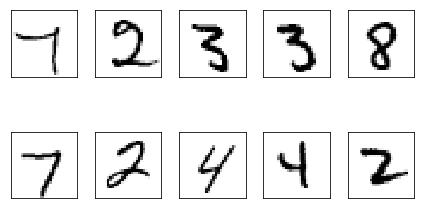

In [45]:
randomIds = np.random.randint(0,60000,10)

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i,n in enumerate(randomIds):
    img = X_train[n,:].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

<div class = "alert alert-success">
**EJERCICIO**: Entrena un modelo de regresión logística con C = 10 y calcula sus prestaciones en el conjunto de test. A lo mejor te resulta de utilidad revisar la [documentación](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
</div>

In [48]:
from sklearn.linear_model import LogisticRegression

# your code here
lr = LogisticRegression(C=10, multi_class = 'multinomial', solver = 'saga', tol = 0.1).fit(X_train,y_train)

In [49]:
score = lr.score(X_test,y_test)
print('ACC (test):',score)

ACC (test): 0.925


<div class = "alert alert-success">
**EJERCICIO**: Calcula y representa la matriz de confusión, ¿qué conclusiones puedes sacar?
</div>

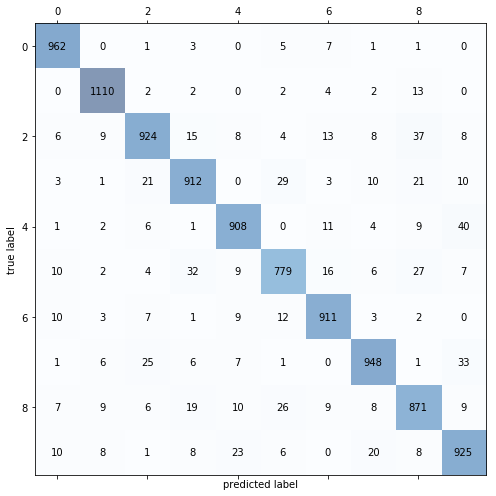

In [50]:
from sklearn.metrics import confusion_matrix

# your code here
y_pred  = lr.predict(X_test)
confmat = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(confmat)